In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
def hamming_dist(x1, x2):
    res = 0
    for c1, c2 in zip(x1, x2):
        if c1 != c2:
            res += 1
    return res


def mul_mat(a, b):
    return np.matmul(a, b) % 2


def get_all_vectors(sz):
    def add_elem(vecs, e):
        return list(map(lambda vec: np.append(vec, e), vecs))
            
    
    res = [np.empty(0, dtype=int)]
    for i in range(sz):
        res = add_elem(res, 0) + add_elem(res, 1)
    return res

In [12]:
n = 10
k = 6
G = np.array([[1, 0, 0, 0, 0, 0, 1, 0, 1, 1],
              [0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
              [0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
              [0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
              [0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
              [0, 0, 0, 0, 0, 1, 0, 1, 0, 1]])

H = np.array([[1, 1, 1, 0, 1, 0, 0, 1, 0, 1],
              [1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
              [1, 1, 0, 1, 0, 1, 1, 1, 0, 0],
              [0, 1, 1, 0, 0, 1, 0, 1, 0, 0]])

H_t = np.transpose(H)
messages = get_all_vectors(k)
codewords = list(map(
    lambda vec: mul_mat(vec, G),
    get_all_vectors(k)
))

In [27]:
def demodulate(signal):
    return np.vectorize(lambda x: 1 if x >= 0 else 0)(signal)


def decode_hard(recieved_signal, possible_codewords):
    recieved_codeword = demodulate(recieved_signal)
    best_dist = np.inf
    best_codeword = None
    for cur_codeword in possible_codewords:
        cur_dist = hamming_dist(cur_codeword, recieved_codeword)
        if cur_dist < best_dist:
            best_dist = cur_dist
            best_codeword = cur_codeword
    return best_codeword


def decode_soft(recieved_signal, possible_codewords):
    best_dist = -np.inf
    best_codeword = None
    for cur_codeword in possible_codewords:
        cur_dist = np.dot(2 * cur_codeword - 1, recieved_signal)
        if cur_dist > best_dist:
            best_dist = cur_dist
            best_codeword = cur_codeword
    return best_codeword


def send_codeword(codeword, Eb, N0):
    noise = np.random.normal(0, math.sqrt(N0 / 2), len(codeword))
    return (2 * codeword - 1) * math.sqrt(Eb) + noise

In [28]:
def send(msg, Eb, N0, encoding, decoder):
    codeword = mul_mat(msg, G) if encoding else msg
    signal = send_codeword(codeword, Eb, N0)
    recieved_codeword = decoder(signal, codewords) if encoding else decoder(signal, messages)
    return 0 if (recieved_codeword == codeword).all() else 1


def calculate_p(Eb, N0, encoding, decoder):
    error_cnt = 0
    retries_cnt = 1000
    for _ in range(retries_cnt):
        for msg in messages:
            error_cnt += send(msg, Eb, N0, encoding, decoder)
    return error_cnt / (retries_cnt * (2 ** k))

In [29]:
snrs = list(np.arange(-2, 12, 0.25))
Eb_fixed = 1.0
N0_fixed = 1.0

def get_N0(snr, Eb):
    return Eb / (10 ** (snr / 10))


def get_Eb(snr, N0):
    return N0 * (10 ** (snr / 10))

In [33]:
hard_encoding_N0 = np.array([calculate_p(Eb_fixed, get_N0(cur_snr, Eb_fixed), True, decode_hard) for cur_snr in tqdm_notebook(snrs)])

In [34]:
hard_no_encoding_N0 = np.array([calculate_p(Eb_fixed, get_N0(cur_snr, Eb_fixed), False, decode_hard) for cur_snr in tqdm_notebook(snrs)])

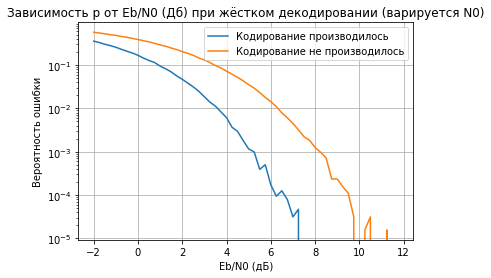

In [45]:
plt.semilogy(snrs, hard_encoding_N0, label='Кодирование производилось')
plt.semilogy(snrs, hard_no_encoding_N0, label='Кодирование не производилось')
plt.legend(loc='upper right')
plt.title('Зависимость p от Eb/N0 (Дб) при жёстком декодировании (варируется N0)')
plt.xlabel('Eb/N0 (дБ)')
plt.ylabel('Вероятность ошибки')
plt.grid(which='major')
plt.show()

In [36]:
hard_encoding_Eb = np.array([calculate_p(get_Eb(cur_snr, N0_fixed), N0_fixed, True, decode_hard) for cur_snr in tqdm_notebook(snrs)])

In [37]:
hard_no_encoding_Eb = np.array([calculate_p(get_Eb(cur_snr, N0_fixed), N0_fixed, False, decode_hard) for cur_snr in tqdm_notebook(snrs)])

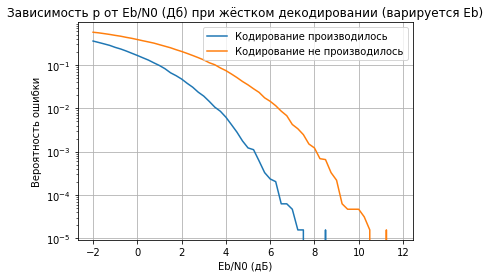

In [46]:
plt.semilogy(snrs, hard_encoding_Eb, label='Кодирование производилось')
plt.semilogy(snrs, hard_no_encoding_Eb, label='Кодирование не производилось')
plt.legend(loc='upper right')
plt.title('Зависимость p от Eb/N0 (Дб) при жёстком декодировании (варируется Eb)')
plt.xlabel('Eb/N0 (дБ)')
plt.ylabel('Вероятность ошибки')
plt.grid(which='major')
plt.show()

In [39]:
soft_encoding_N0 = np.array([calculate_p(Eb_fixed, get_N0(cur_snr, Eb_fixed), True, decode_soft) for cur_snr in tqdm_notebook(snrs)])

In [40]:
soft_no_encoding_N0 = np.array([calculate_p(Eb_fixed, get_N0(cur_snr, Eb_fixed), False, decode_soft) for cur_snr in tqdm_notebook(snrs)])

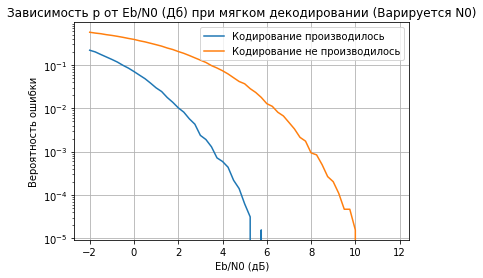

In [47]:
plt.semilogy(snrs, soft_encoding_N0, label='Кодирование производилось')
plt.semilogy(snrs, soft_no_encoding_N0, label='Кодирование не производилось')
plt.legend(loc='upper right')
plt.title('Зависимость p от Eb/N0 (Дб) при мягком декодировании (Варируется N0)')
plt.xlabel('Eb/N0 (дБ)')
plt.ylabel('Вероятность ошибки')
plt.grid(which='major')
plt.show()

In [42]:
soft_encoding_Eb = np.array([calculate_p(get_Eb(cur_snr, N0_fixed), N0_fixed, True, decode_soft) for cur_snr in tqdm_notebook(snrs)])

In [49]:
soft_no_encoding_Eb = np.array([calculate_p(get_Eb(cur_snr, N0_fixed), N0_fixed, False, decode_soft) for cur_snr in tqdm_notebook(snrs)])

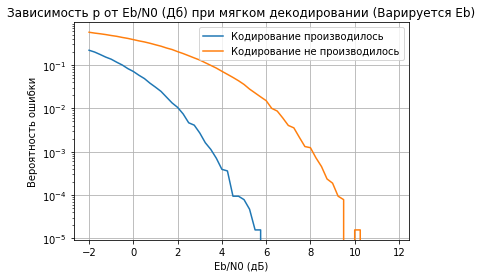

In [50]:
plt.semilogy(snrs, soft_encoding_Eb, label='Кодирование производилось')
plt.semilogy(snrs, soft_no_encoding_Eb, label='Кодирование не производилось')
plt.legend(loc='upper right')
plt.title('Зависимость p от Eb/N0 (Дб) при мягком декодировании (Варируется Eb)')
plt.xlabel('Eb/N0 (дБ)')
plt.ylabel('Вероятность ошибки')
plt.grid(which='major')
plt.show()

In [56]:
desired_p = 1e-5


def get_profit(encoding, no_encoding):
    abs_encoding = abs(encoding - desired_p)
    abs_no_encoding = abs(no_encoding - desired_p)
    return snrs[np.argmin(abs_no_encoding)] - snrs[np.argmin(abs_encoding)]


hard_N0_profit = get_profit(hard_encoding_N0, hard_no_encoding_N0)
hard_Eb_profit = get_profit(hard_encoding_Eb, hard_no_encoding_Eb)

soft_N0_profit = get_profit(soft_encoding_N0, soft_no_encoding_N0)
soft_Eb_profit = get_profit(soft_encoding_Eb, soft_no_encoding_Eb)

hard_average_profit = (hard_Eb_profit + hard_N0_profit) / 2
soft_average_profit = (soft_N0_profit + soft_Eb_profit) / 2

hard_average_profit, soft_average_profit

(3.0, 4.375)

Вывод: Энергетический выигрыш при мягком кодировании составляет 4.375 дБ, при жёстком - 3.0 дБ